In [687]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report  
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error

In [688]:
df = pd.read_csv('../data/train.csv', index_col=0, parse_dates=True)

# Data columns:  

In [689]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [690]:
for col in ['season', 'holiday', 'workingday', 'weather',]:
    print(df[col].value_counts())

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
0    10575
1      311
Name: holiday, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64


# Creating new columns

In [691]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['year'] = df.index.year
df['month_count'] = df['month']+(df['year']-2011)*12
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'weekday', 'month', 'year', 'month_count'],
      dtype='object')

Fix weather value '4' (heavy rain e.t.c) that apears only once

In [692]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [693]:
#df['weather'] = df['weather'].replace(4, 3)
#df['weather'][df['weather']==4] = 3

In [694]:
for col in ['season', 'holiday', 'workingday', 'weather',]:
    print(df[col].value_counts())

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
0    10575
1      311
Name: holiday, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64


# Data Exploration highlights

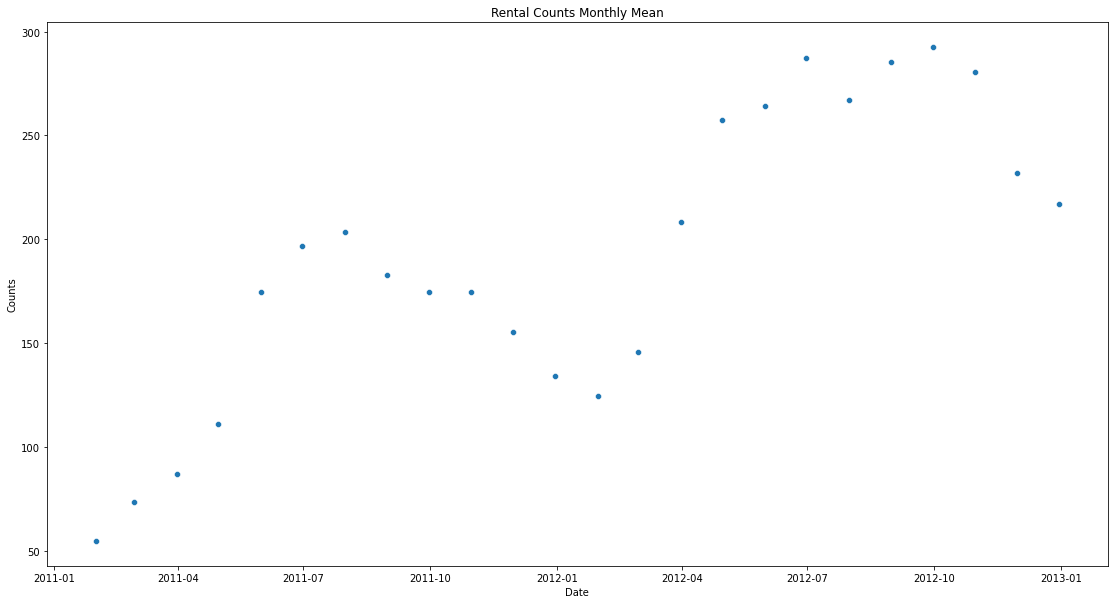

In [695]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('M').mean(), x = 'datetime', y ='count')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Monthly Mean')
plt.show()

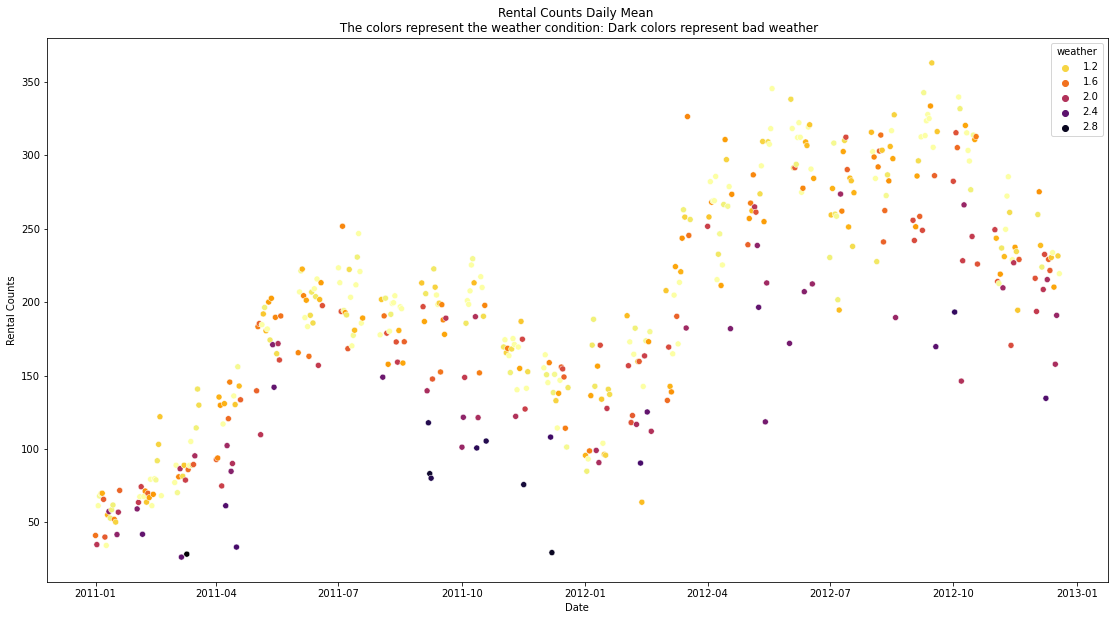

In [696]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('D').mean(), x = 'datetime', y ='count',hue='weather',palette="inferno_r")
plt.ylabel('Rental Counts')
plt.xlabel('Date')
plt.title('Rental Counts Daily Mean \n The colors represent the weather condition: Dark colors represent bad weather')
plt.show()

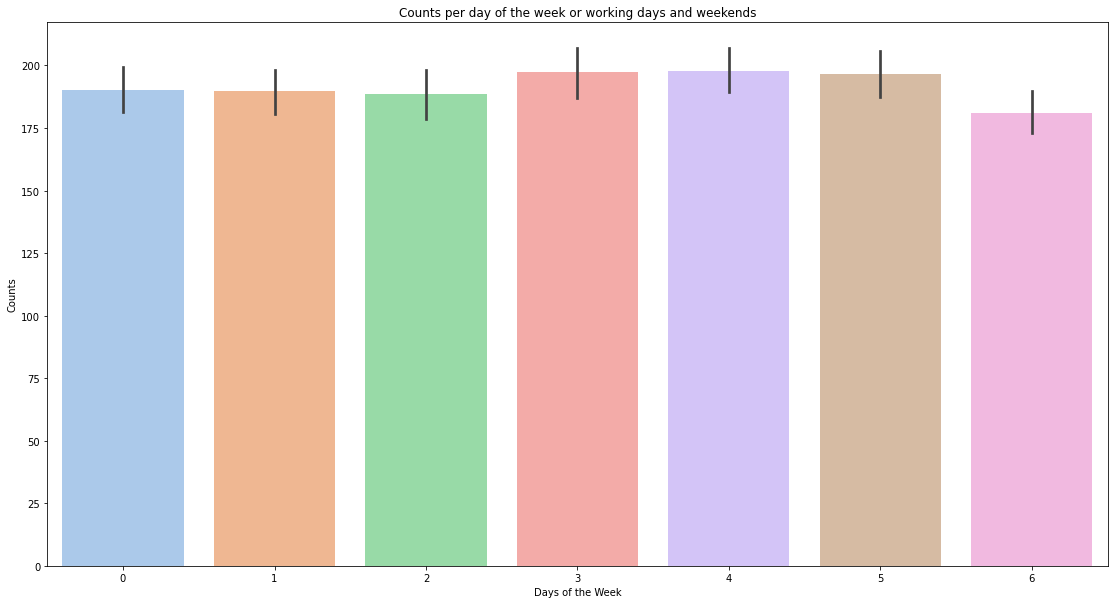

In [697]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'weekday', y ='count', palette='pastel', ) #hue = 'workingday', 
plt.xlabel('Days of the Week')
plt.ylabel('Counts')
plt.title('Counts per day of the week or working days and weekends')
plt.show()

In [698]:
df['workingday'].value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

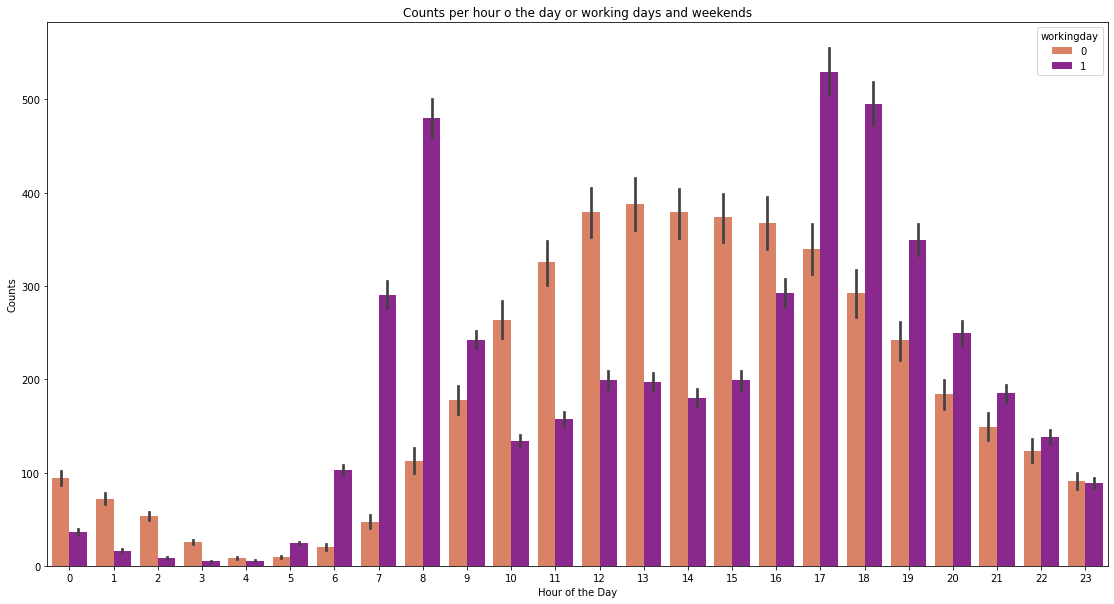

In [699]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'workingday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour o the day or working days and weekends')
plt.show()

# Building the model

In [700]:
y = df['count']
X = df[['weather', 'temp', 'atemp', 'humidity', 'windspeed', 
        'holiday', 'workingday', 
        'hour', 'weekday', 'month', 'month_count', 'season', 
        ]]

In [701]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 

<AxesSubplot:>

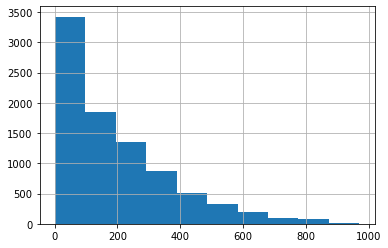

In [702]:
y_train.hist()

# Transform the Count variable: 
### We use a logarithmic transformation to optimize the target's distribution. Idealy a normal distribution for linear models.

* In this way we also make sure we do not predict negative counts

In [703]:
ylog_train = np.log1p(y_train)
ylog_test = np.log1p(y_test)

<AxesSubplot:>

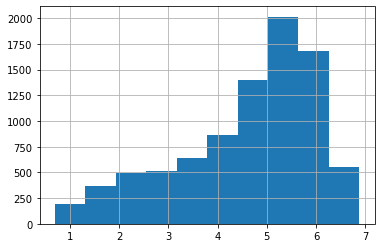

In [704]:
ylog_train.hist()

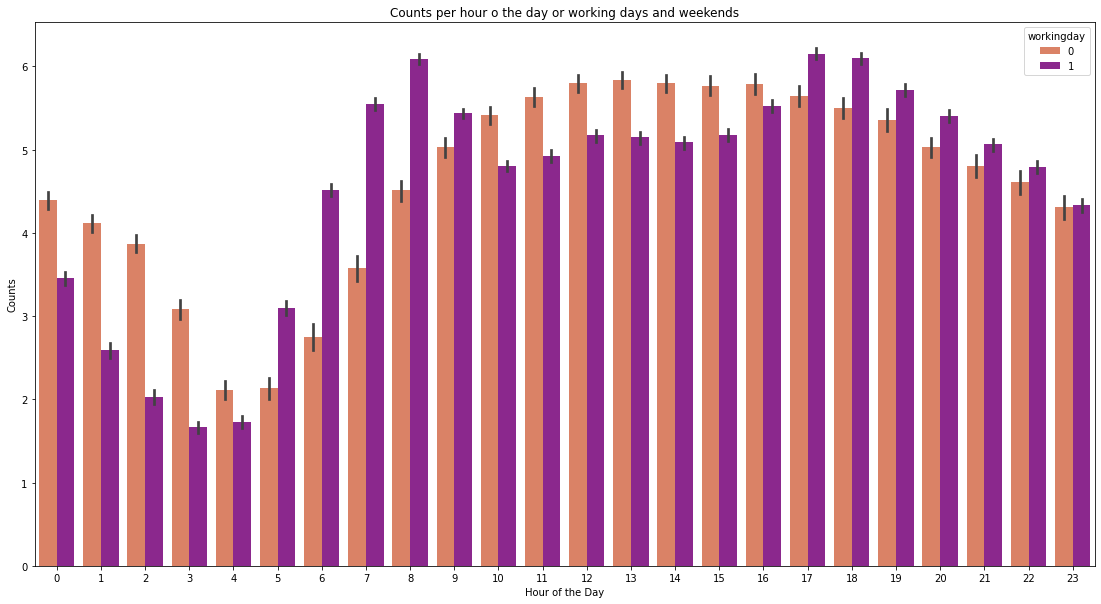

In [705]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y =ylog_train, hue = 'workingday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour o the day or working days and weekends')
plt.show()

Data transormation pipelines:

In [706]:
numerical_pipeline = Pipeline([
    ('num_scaler',StandardScaler()),
    ('polynomial', PolynomialFeatures(degree= 3, include_bias=False)),
])

In [707]:
categorical_pipeline = Pipeline([
    ('categorical_ohe',OneHotEncoder(sparse=False, drop='first',)),
])

In [708]:
polynomial_pipeline_4 = Pipeline([
    ('polynomial', PolynomialFeatures(degree= 4,)),
])

In [711]:
column_transformer = ColumnTransformer([
    ('numerical_pipeline_a',numerical_pipeline,['atemp', ]), 
    ('numerical_pipeline_b',numerical_pipeline,['humidity', ]), 
    ('numerical_pipeline_c',numerical_pipeline,['windspeed',]),                       #scal,poly3
    ('polynomial_4', polynomial_pipeline_4, ['month_count',]),                                             #poly4
    ('categorical_pipeline',categorical_pipeline,['hour', 'weekday', 'workingday', 'holiday', 'weather',]),#ohe
])

In [712]:
column_transformer.fit(X_train) 
X_train_fe = column_transformer.transform(X_train) 
X_test_fe = column_transformer.transform(X_test)

In [713]:
df_fe=pd.DataFrame(X_train_fe, columns=column_transformer.get_feature_names_out())
df_fe.columns

Index(['numerical_pipeline_a__atemp', 'numerical_pipeline_a__atemp^2',
       'numerical_pipeline_a__atemp^3', 'numerical_pipeline_b__humidity',
       'numerical_pipeline_b__humidity^2', 'numerical_pipeline_b__humidity^3',
       'numerical_pipeline_c__windspeed', 'numerical_pipeline_c__windspeed^2',
       'numerical_pipeline_c__windspeed^3', 'polynomial_4__1',
       'polynomial_4__month_count', 'polynomial_4__month_count^2',
       'polynomial_4__month_count^3', 'polynomial_4__month_count^4',
       'categorical_pipeline__hour_1', 'categorical_pipeline__hour_2',
       'categorical_pipeline__hour_3', 'categorical_pipeline__hour_4',
       'categorical_pipeline__hour_5', 'categorical_pipeline__hour_6',
       'categorical_pipeline__hour_7', 'categorical_pipeline__hour_8',
       'categorical_pipeline__hour_9', 'categorical_pipeline__hour_10',
       'categorical_pipeline__hour_11', 'categorical_pipeline__hour_12',
       'categorical_pipeline__hour_13', 'categorical_pipeline__hour_1

[('numerical_pipeline_a__atemp', 3.4048406874390946), ('numerical_pipeline_a__atemp^2', 1.0464723758679755), ('numerical_pipeline_a__atemp^3', 2.759412560854883), ('numerical_pipeline_b__humidity', 2.5258473616216266), ('numerical_pipeline_b__humidity^2', 0.9944430848087573), ('numerical_pipeline_b__humidity^3', 1.3632428882918186), ('numerical_pipeline_c__windspeed', 1.1211144507502149), ('numerical_pipeline_c__windspeed^2', 0.8724481267456706), ('numerical_pipeline_c__windspeed^3', 0.7553016886579925), ('polynomial_4__1', nan), ('polynomial_4__month_count', 2.221510152286165), ('polynomial_4__month_count^2', 2.175459978145176), ('polynomial_4__month_count^3', 2.073366379601089), ('polynomial_4__month_count^4', 1.9574533618213528), ('categorical_pipeline__hour_1', 1.1504443850030615), ('categorical_pipeline__hour_2', 1.3395801379847485), ('categorical_pipeline__hour_3', 2.239575237147522), ('categorical_pipeline__hour_4', 3.474764294823822), ('categorical_pipeline__hour_5', 1.83250360

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


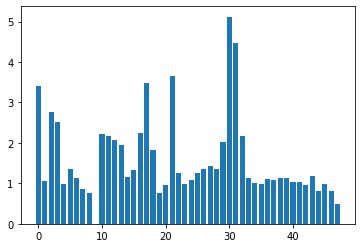

In [714]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train_fe, y_train)
#X_train_fs = fs.transform(X_train)
#X_test_fs = fs.transform(X_test)
plt.bar([i for i, _ in enumerate(fs.scores_)], fs.scores_)
print([(df_fe.columns[i],fs.scores_[i]) for i, _ in enumerate(fs.scores_)])

# What is done until now is:
##                            1) Follow the general x^4 monthly mean trend. This should be replaced with a sinusoid + a linear increase in general but for the two years is fine.
##                            2) Define a factor to add/subtract according to the day of the week, the hour, holiday or not, and the weather conditions.
##                            3) Include temperature, humidity, and wind speed with an x^3 fitting curve, although a logarithm would sound better intuitively since our perception is logarithmic
## With this feature engineering, a linear regression scored 0.62582.
##                            But what if the weather for example affects the weekends more than Mondays? Or if humidity affects the winter months more? Our model until now cannot include such information. A first try is done here by including interactions. For now, all interactions are included but more work needs to be done here to separate the important ones. This improves the score aprox. 0.2

In [715]:
poly = PolynomialFeatures(degree= 2, interaction_only=True, include_bias=False)
poly.fit(X_test_fe)
X_train_fe_int = poly.transform(X_train_fe)
X_test_fe_int = poly.transform(X_test_fe)
X_test_fe_int.shape

(2178, 1176)

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   9  615  616  617  618  619  620  621  622  623  624  625  626  627
  628  629  630  631  632  633  634  635  636  647  648  649  650  651
  652  653  654  655  656  657  658  659  660  661  662  663  664  665
  666  667  668  679  680  681  682  683  684  685  686  687  688  689
  690  691  692  693  694  695  696  697  698  699  710  711  712  713
  714  715  716  717  718  719  720  721  722  723  724  725  726  727
  728  729  740  741  742  743  744  745  746  747  748  749  750  751
  752  753  754  755  756  757  758  769  770  771  772  773  774  775
  776  777  778  779  780  781  782  783  784  785  786  797  798  799
  800  801  802  803  804  805  806  807  808  809  810  811  812  813
  824  825  826  827  828  829  830  831  832  833  834  835  836  837
  838  839  850  851  852  853  854  855  856  857  858  859  860  861
  862  863  864

<BarContainer object of 1176 artists>

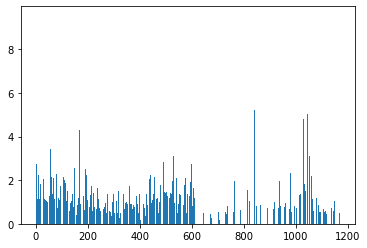

In [716]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train_fe_int, y_train)
#X_train_fs = fs.transform(X_train)
#X_test_fs = fs.transform(X_test)
plt.bar([i for i, _ in enumerate(fs.scores_)], fs.scores_)
#print([(poly.get_feature_names_out()[i],fs.scores_[i]) for i, _ in enumerate(fs.scores_)])

In [717]:
m = LinearRegression()
m.fit(X_train_fe_int,ylog_train)
m.score(X_train_fe_int,ylog_train)

0.963978820881941

In [718]:
cross_val_score(m, X_train_fe_int, ylog_train,cv = 5).mean()

0.952843785141296

In [719]:
m.score(X_test_fe_int,ylog_test)

0.953734079386344

In [720]:
y_predlog = m.predict(X_test_fe_int)

In [721]:
ypred = np.exp(y_predlog)-1

In [722]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_test, ypred)


0.09523863815897272

In [723]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, ypred)

26.445001429401756

In [724]:
train_pred_log = m.predict(X_train_fe_int)
train_pred = np.exp(train_pred_log)-1 
diff = (train_pred - y_train)
diff.describe()

count    8708.000000
mean       -2.463284
std        39.954459
min      -365.008705
25%       -14.794330
50%        -0.530390
75%        10.607635
max       364.982735
Name: count, dtype: float64

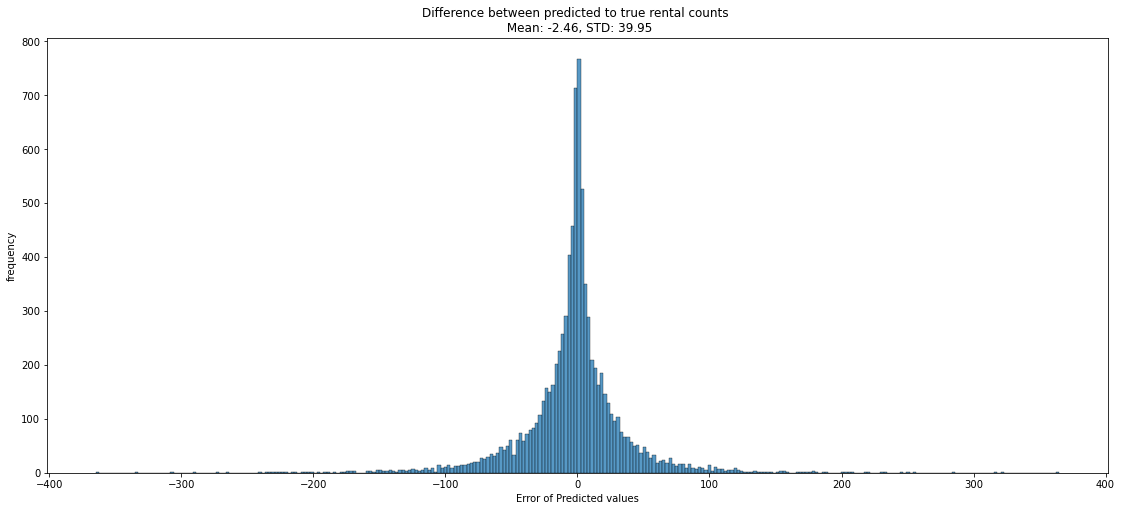

In [725]:
plt.figure(figsize=(19,8))
sns.histplot(diff)
plt.ylabel('frequency')
plt.xlabel('Error of Predicted values')
plt.title(f'Difference between predicted to true rental counts \n Mean: {diff.mean():.2f}, STD: {diff.std():.2f}')
plt.show()

In [726]:
X_train['ypred'] = m.predict(X_train_fe_int)
X_train['ytrue'] = ylog_train

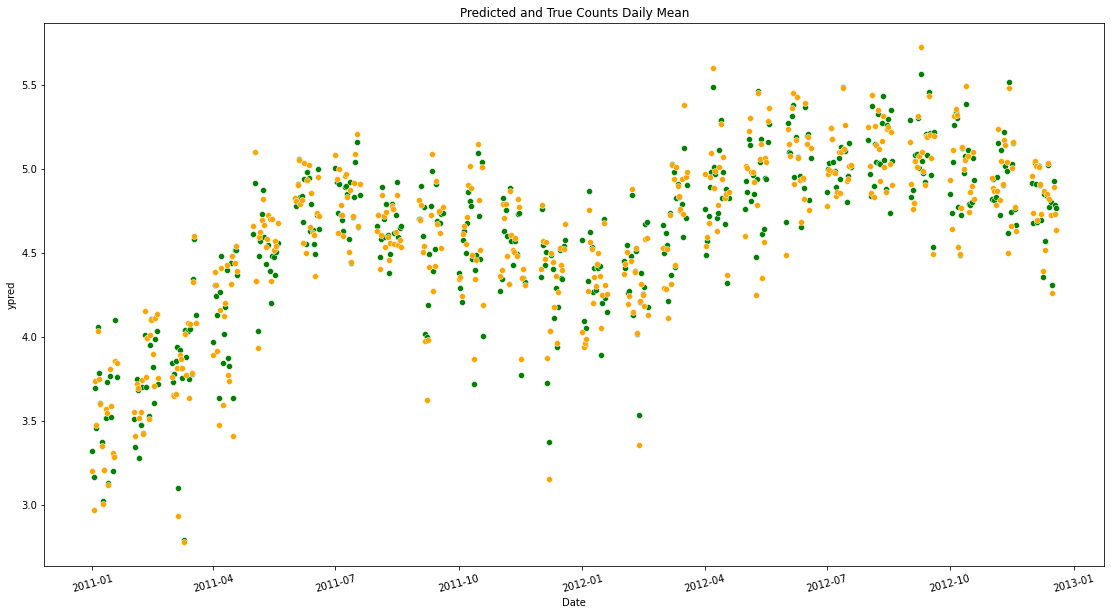

In [727]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =X_train.resample('D').mean(), x = 'datetime', y = 'ypred', color = 'green')
sns.scatterplot(data =X_train.resample('D').mean(), x = 'datetime', y = 'ytrue', color = 'orange' )
plt.xticks(rotation=15)
#plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Predicted and True Counts Daily Mean')
plt.show()

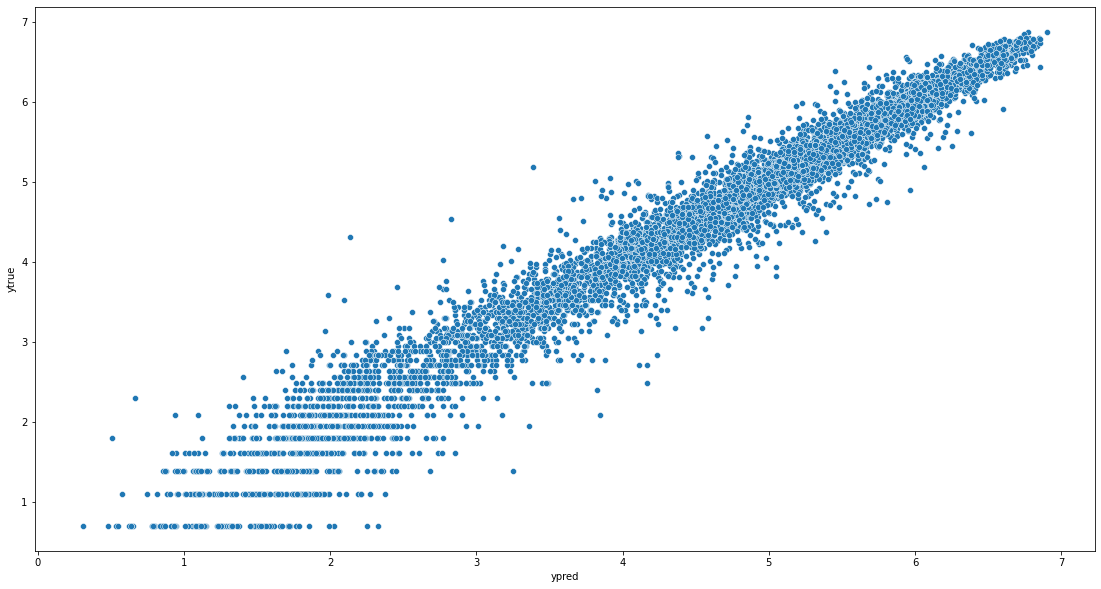

In [728]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =X_train, y ='ytrue',  x ='ypred', )
#sns.barplot(data =X_train, x = 'hour', )
#plt.xlabel('Hour of the Day')
#plt.ylabel('Counts')
#plt.title('Counts per hour o the day or working days and weekends')
plt.show()

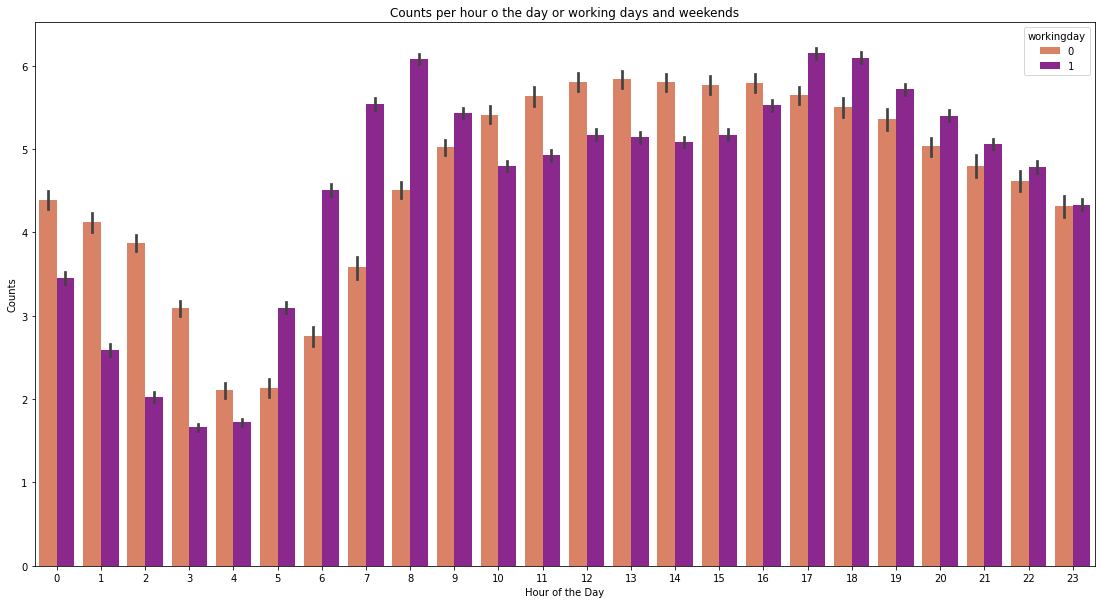

In [729]:
plt.figure(figsize=(19,10))
#sns.barplot(data =X_train, x = 'hour', y ='ytrue', hue = 'workingday', palette='plasma_r', )
sns.barplot(data =X_train, x = 'hour', y ='ypred', hue = 'workingday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour o the day or working days and weekends')
plt.show()

In [730]:
df_k = pd.read_csv('../data/test.csv', index_col=0, parse_dates=True)
df_k.shape

(6493, 8)

In [731]:
df_k['hour'] = df_k.index.hour
df_k['weekday'] = df_k.index.weekday
df_k['month'] = df_k.index.month
df_k['year'] = df_k.index.year
df_k['month_count'] = df_k['month']+(df_k['year'] - 2011)*12
#df_k['weather'][df_k['weather']==4] = 3

In [732]:
X_test_kaggle = df_k[['season', 'holiday', 'workingday', 'weather', 'temp',
                     'atemp', 'humidity', 'windspeed', 'weekday', 'hour', 'month_count',]]

In [733]:
df_k['weather'].value_counts()

1    4221
2    1710
3     560
4       2
Name: weather, dtype: int64

In [734]:
X_test_kaggle_fe = column_transformer.transform(X_test_kaggle) 
X_test_kaggle_fe = poly.transform(X_test_kaggle_fe) 

In [735]:
y_predlog_k = m.predict(X_test_kaggle_fe)
ypred_k = np.exp(y_predlog_k)-1


### Making sure there are no negative values that would give error in kaggle scoring

In [736]:
np.where(ypred_k<0)

(array([], dtype=int64),)

In [737]:
df_s = pd.read_csv('../data/sampleSubmission.csv', index_col=0, parse_dates=True)
df_s['count'] = ypred_k
pd.DataFrame(df_s).to_csv("predictions")

# Kaggle score 0.44596

# lowered to 0.43872 after corecting pipeline for temp hum and wind